In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from IPython.display import clear_output

import gc

In [2]:
sample_size  = int(1e+6)
df  = pd.read_hdf(f'/Users/asugu/Desktop/b_tag_DNN/data/all_data_{sample_size}.hdf5', key='data') 

df = df.astype(np.float32)  
df = df.loc[df['jet_flavor'] == 5.0, :]   # Bottoms

#df_charm = df.loc[df['jet_flavor'] == 4.0, :] # charms
#df_light = df.loc[df['jet_flavor'] == 0.0, :] # lights

#df = pd.concat([df_charm,df_light], axis=0)

In [3]:
col_names = df.keys()
target_col_name = "jet_flavor"
input_col_names = [col_name for col_name in col_names if col_name != target_col_name]

df.replace({"inf": 0, "-inf": 0}, inplace=True)
df = df[(np.abs(df-df.mean()) <= 10*df.std()).all(axis=1)]

inputs = df[input_col_names]

del df
gc.collect()

47

In [4]:
train_inputs, val_inputs = train_test_split(inputs, test_size = 0.2, shuffle = True, random_state = 42)

del inputs
gc.collect()

scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs  = scaler.transform(val_inputs)

train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, code):
        super(Autoencoder, self).__init__()
        mult=int((input_size/code)**(0.3334))       # change the cube root if you want to change number of layers
        
        
        self.enc1 = nn.Linear(input_size, code*mult*mult)
           
            #torch.nn.Linear(code*mult*mult*mult, code*mult*mult),
            #torch.nn.ReLU(),
        self.enc2 = nn.Linear(code*mult*mult, code*mult)
           
        self.enc3 = nn.Linear(code*mult, code)
        
        self.relu = torch.nn.ReLU()
       
        self.dec1 = torch.nn.Linear(code, code*mult)
           
        self.dec2 = torch.nn.Linear(code*mult, code*mult*mult)
          
           # torch.nn.Linear(code*mult*mult, code*mult*mult*mult),
            #torch.nn.ReLU(),
        self.dec3 = torch.nn.Linear(code*mult*mult, input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        resid1 = x
        x = self.enc1(x)
        x = self.relu(x)
        resid2 = x
        x = self.enc2(x)
        x = self.relu(x)
        resid3 = x
        x = self.enc3(x)
        x = self.relu(x)

        
        x = self.dec1(x)
        x = self.relu(x) 
        x = x + resid3
        x = self.relu(x)

        x = self.dec2(x)
        x = self.relu(x)
        x = x + resid2
        x = self.relu(x)

        x = self.dec3(x)
        x = x + resid1
        x = self.sigmoid(x)
        
        # call decoder in train loop to get encoder only
        return x

In [6]:
batchsize = int(len(train_inputs)/148)
print(batchsize)
trainloader = DataLoader(train_inputs, batch_size = batchsize , drop_last=True )

2003


In [7]:
num_epochs = 30
learning_rate = 0.00001
input_size  = len(input_col_names)

autoencoder = Autoencoder(input_size=input_size, code=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)


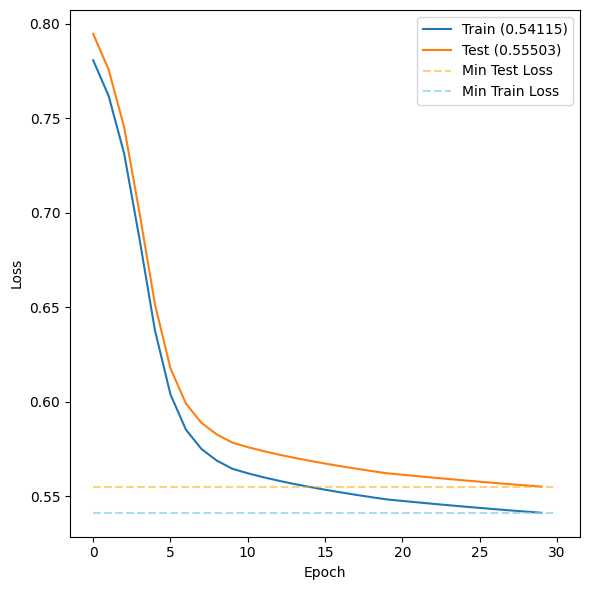

Training complete


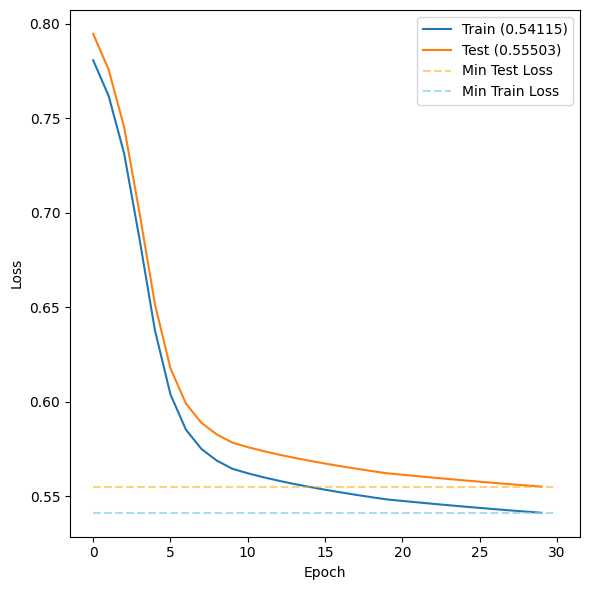

In [8]:
train_losses = []
val_losses = []
fig, axs = plt.subplots(1, figsize=(6, 6))
for i_epoch in range(num_epochs):
    autoencoder.train() 
    for i_batch,train_input in enumerate(trainloader):
        train_input = train_input.float()
        optimizer.zero_grad()
        
        train_pred = autoencoder(train_input)
        loss = criterion(train_pred, train_input)
        
        if not torch.isnan(loss): 
            loss.backward()
            optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        train_preds = autoencoder(train_inputs)
        val_preds = autoencoder(val_inputs)
   
        train_loss = criterion(train_preds, train_inputs)
        val_loss = criterion(val_preds, val_inputs)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
    scheduler.step()

    axs.clear()
    axs.plot(train_losses, label='Train ({:.5f})'.format(train_losses[-1]))
    axs.plot(val_losses, label='Test ({:.5f})'.format(val_losses[-1]))
    axs.plot([0, len(train_losses)], [min(val_losses), min(val_losses)], '--', color='orange' ,alpha=0.5, label='Min Test Loss')
    axs.plot([0, len(train_losses)], [min(train_losses), min(train_losses)], '--', color = 'skyblue',alpha=0.7, label='Min Train Loss')
    axs.set_xlabel('Epoch')
    axs.set_ylabel('Loss')
    axs.legend()
    
    fig.tight_layout()
    clear_output(wait=True)
    display(fig)

print('Training complete')


In [9]:

del train_inputs, val_inputs

2696

In [10]:
# _____PreProcessing for Charm and Light Jets_____

df  = pd.read_hdf(f'/Users/asugu/Desktop/b_tag_DNN/data/all_data_{sample_size}.hdf5', key='data')  
df = df.astype(np.float32)  

bottoms = df.loc[df['jet_flavor'] == 5.0, :]
lights = df.loc[df['jet_flavor'] == 0.0, :]
charms = df.loc[df['jet_flavor'] == 4.0, :]

del df
gc.collect()

49

In [11]:
col_names = lights.keys()
target_col_name = "jet_flavor"
input_col_names = [col_name for col_name in col_names if col_name != target_col_name]

lights.replace({"inf": 0, "-inf": 0}, inplace=True)
lights = lights[(np.abs(lights-lights.mean()) <= 10*lights.std()).all(axis=1)]

light_input = lights[input_col_names]

charms.replace({"inf": 0, "-inf": 0}, inplace=True)
charms = charms[(np.abs(charms-charms.mean()) <= 10*charms.std()).all(axis=1)]

charm_input = charms[input_col_names]

bottoms.replace({"inf": 0, "-inf": 0}, inplace=True)
bottoms = charms[(np.abs(bottoms-bottoms.mean()) <= 10*bottoms.std()).all(axis=1)]

bottom_input = bottoms[input_col_names]

scaler = StandardScaler()
bottom_input = scaler.fit_transform(bottom_input)
charm_input = scaler.fit_transform(charm_input)
light_input = scaler.fit_transform(light_input)
bottom_input = torch.tensor(bottom_input,  dtype=torch.float32)
charm_input = torch.tensor(charm_input,  dtype=torch.float32)
light_input = torch.tensor(light_input,  dtype=torch.float32)
del charms,lights
gc.collect()

/var/folders/42/96sdrm9s2g3bbd66hr6_pqzr0000gn/T/ipykernel_6668/3255916518.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bottoms = charms[(np.abs(bottoms-bottoms.mean()) <= 10*bottoms.std()).all(axis=1)]


0

In [12]:
light_loader = DataLoader(light_input, batch_size=1000, shuffle=True)
charm_loader = DataLoader(charm_input, batch_size=1000, shuffle=True)
bottom_loader = DataLoader(charm_input, batch_size=1000, shuffle=True)
autoencoder.eval()
light_losses = []
charm_losses = []
bottom_losses = []
with torch.no_grad():
    for inputs in light_loader:
        outputs = autoencoder(inputs)
        batch_losses = criterion(outputs, inputs).tolist()
        light_losses.append(batch_losses)

    for inputs in charm_loader:
        outputs = autoencoder(inputs)
        batch_losses = criterion(outputs, inputs).tolist()
        charm_losses.append(batch_losses)
    
    for inputs in bottom_loader:
        outputs = autoencoder(inputs)
        batch_losses = criterion(outputs, inputs).tolist()
        bottom_losses.append(batch_losses)
        
del charm_input, light_input, bottom_input
gc.collect()

0

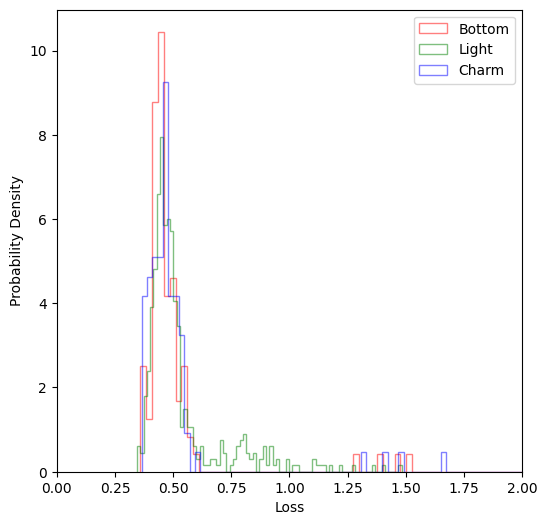

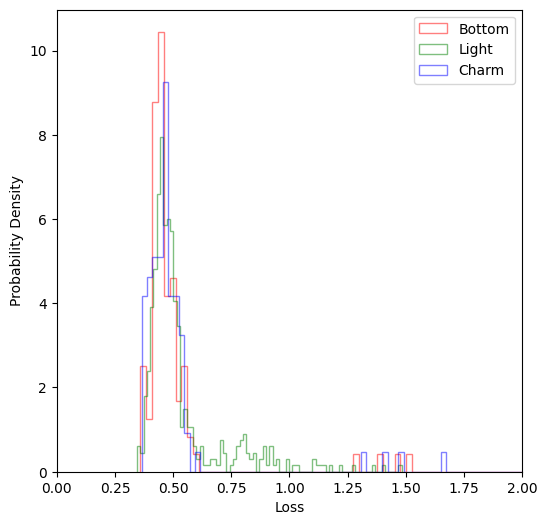

In [13]:
cmap = plt.colormaps.get_cmap('Spectral')
fig ,ax = plt.subplots(1, figsize=(6, 6))

ax.hist(bottom_losses,density=True,bins=80, color="r", histtype = 'step', alpha = 0.5,label='Bottom')
#ax.hist(val_loss_hist,density=True,bins=40, histtype = 'step', alpha = 0.5,label='Bottom (Test)')
ax.hist(light_losses,density=True,bins=80, color="g", histtype = 'step', alpha = 0.5,label='Light')
ax.hist(charm_losses,density=True,bins=80, color="b", histtype = 'step', alpha = 0.5,label='Charm')

ax.set_xlabel('Loss')
ax.set_xlim([0,2])
ax.set_ylabel('Probability Density')
ax.legend()
    
#fig.tight_layout()
display(fig)